## **Import Libraries**

In [ ]:
import math
import datetime
import numpy as np 
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# Dimensionality Reduction Methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Feature selection modules
from sklearn.feature_selection import mutual_info_classif,RFE,RFECV
from sklearn.feature_selection import mutual_info_regression

# Classification modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Regression modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor

# Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error, r2_score

# Split methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold as cross_valid_kfold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold  as cross_valid_stratified_kf
from sklearn.model_selection import StratifiedShuffleSplit

#Smote
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
seed=42

!pip install plotly
import plotly.graph_objs as plt_go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, plot, iplot

import warnings
warnings.filterwarnings('ignore')

## **Fetch Dataset**

>#### The dataset is downloaded from Kaggle and stored on google drive due to its large size. Initially I have found out that there were no missing values however, this dataset is highly imbalanced.




In [ ]:
get_ds = "https://raw.githubusercontent.com/Rumsha001/ML2/main/dataset/SalesKaggle3.csv"

df = pd.read_csv(get_ds)
# df.dropna(axis=0, inplace=True)
df

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,6.827430e+05,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1.016014e+06,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,3.404640e+05,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,3.340110e+05,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1.287938e+06,121.95,2010,28,4.00,23.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198912,208023,Active,109683,NaN,NaN,D,7,1,2.101869e+05,72.87,2006,54,8.46,60.59
198913,208024,Active,416462,NaN,NaN,D,8,1,4.555041e+05,247.00,2009,65,8.40,74.85
198914,208025,Active,658242,NaN,NaN,S,2,1,1.692746e+05,50.00,2012,23,23.98,32.62
198915,208026,Active,2538340,NaN,NaN,S,2,1,3.775266e+05,46.95,2001,23,27.42,37.89


## **Helper Functions**

In [ ]:
# Get percenage of missing values
def get_missing_per(df):
  total = df.isna().sum()
  percent = (total/df.isna().count()*100) 
  return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


# columns to convert to date format
def change_type_to_date(df, to_date):
  # Deal with incorrect data in date column
  for i in to_date:
    df[i] = pd.to_datetime(df[i], errors='coerce')
  return df
    
 # columns to convert to numerical format
def change_type_to_numeric(df, to_numeric):
  # Deal with incorrect data in numeric columns
  for i in to_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
  return df
    
# columns to delete
def drop_useless_columns(df, cols_to_delete):
  # Drop useless columns before dealing with missing values
  for i in cols_to_delete:
    df.drop(i, axis=1, inplace=True)
  return df
    
#drop all rows which contain more than 40% missing values
def drop_useless_rows(df):
  min_threshold = math.ceil(len(df.columns)*0.4)
  df = df.dropna(thresh=min_threshold)
  return df
    
# drop rows in which columns specified by the driver program has missing values
def drop_na_rows(df, cols_to_drop_na_rows):
  for i in cols_to_drop_na_rows:
    df = df.drop(df[df[i].isnull()].index)
  return df
    
# Deal with missing values according to map, e.g., {'age': df['age'].median(), 'city': 'Karachi'}
def fill_na_vals(df, fill_na_map):
  for col,val in fill_na_map.items():
    df[col].fillna(val, inplace=True)
  return df
    
# Deal with missing values according to the interpolation
def fill_na_interpolate(df, cols_to_interpolate):
  for i in cols_to_interpolate:
    df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
  return df


#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    # print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    # for col in numcols:
    #     fig = plt.figure(figsize = (5,5))
    #     sns.boxplot(df[col], color='grey', linewidth=1)
    #     plt.tight_layout()
    #     plt.title(col)
    #     plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(20,15),
                 color='#86bf91', zorder=2, rwidth=0.9)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df

def convert_binary_col(df, cols=[]):
  dict = {False:0,True:1}
  for col in cols:
    df[col] = df[col].map(dict)
  return df


# Define Catplot function and Barplot function
def cat_plot(df_pd, feature, cut=12):
    temp = df_pd.loc[:, [feature, "Churn"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="Churn",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(df_pd, feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "Churn"]]
    else:
        temp = df_pd.loc[:, [feature, "Churn"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="Churn", data=temp)
    else:
        ax = sns.barplot(x=feature, y="Churn", data=temp)

    if logscale:
        ax.set_yscale("log")

## **Data Preprocessing and EDA**

> ### This Preprocessing and EDA is crucial to run.

* After performing detailed EDA, I have figured out that there were some missing values in some columns. I replaced "NaN" with 0. Also, there are some important columns which can play a part to examine the dataset in terms of predicting the chances of products to be "Sold".

* Pairplots, heatmap, lineplot, boxplot, and dist plots; all are used for analysing the relationship between dependent variables.

* I have dropped some variables which were not looking important for the analysis.

* Further, it was important to categorise products on the basis of their Sold Count, Price, File Type and Sold Flag.

* It will look like I'm generating another independent variable called as Class, but since we have given historical data and we need to make predictions on its basis that's why it is important to assign class to each product.

* Note that, this class is not telling that the product will be sold or not, though it is categorizing product's potential on the given information.

* Another important point, it was very difficult to choose predictors as their significance towards the given indicator is very low. Therefore, I supposed that a new variable was needed.

* Lastly, I did not prefer to perform scaling as the purpose of binary data Vs. numerical data somewhat got mixed with each other. Therefore in order to maintain a balance between their values, I manually normalised numerical columns by divinding each of their values with respective column's mean.

In [ ]:
get_missing_per(df)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
Total,0.0,0.0,0.0,122921.000000,122921.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,61.795121,61.795121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['SoldFlag'].replace(np.nan, 0, inplace=True)
df['SoldCount'].replace(np.nan, 0, inplace=True)
get_missing_per(df)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# checking summary of data
print("Sales Analysis - Total no .of rows:", df.shape[0]," columns:", df.shape[1])
df.describe()

Sales Analysis - Total no .of rows: 198917  columns: 14


,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,106483.543242,8.613626e+05,0.065334,0.123137,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,60136.716784,8.699794e+05,0.247115,0.739101,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,2.000000,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55665.000000,2.172520e+05,0.000000,0.000000,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,108569.000000,6.122080e+05,0.000000,0.000000,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,158298.000000,9.047510e+05,0.000000,0.000000,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000
max,208027.000000,3.960788e+06,1.000000,73.000000,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,14140.210000,19138.790000


In [ ]:
#count of the historical and active state 
print("Historical Records:  ",df[df['File_Type'] == 'Historical']['SKU_number'].count())
print("Acive Records:  ",df[df['File_Type'] == 'Active']['SKU_number'].count())

# Split the dataset into two parts based on the file_type 
df_hist = df[df['File_Type'] == 'Historical']
df_act = df[df['File_Type'] == 'Active']


df = drop_useless_columns(df,['Order', 'SKU_number','MarketingType','ReleaseYear'])
print("*****************")
print(df.nunique())

Historical Records:   75996
Acive Records:   122921
*****************
File_Type                2
SoldFlag                 2
SoldCount               37
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64


In [ ]:
dict1 = {"Historical":0.0,"Active":1.0}
df['File_Type'] = df['File_Type'].map(dict1)
print(df['New_Release_Flag'].value_counts())
print(df['File_Type'].value_counts())


1    127754
0     71163
Name: New_Release_Flag, dtype: int64
1.0    122921
0.0     75996
Name: File_Type, dtype: int64


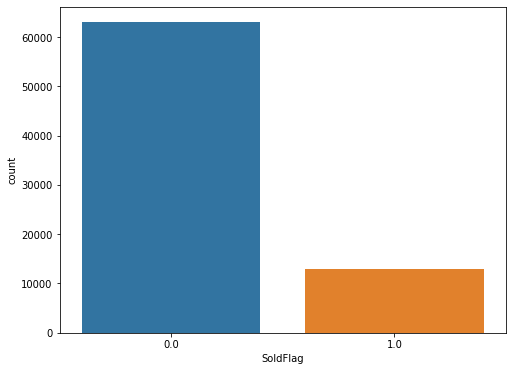

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df.SoldFlag)

(12996, 10)


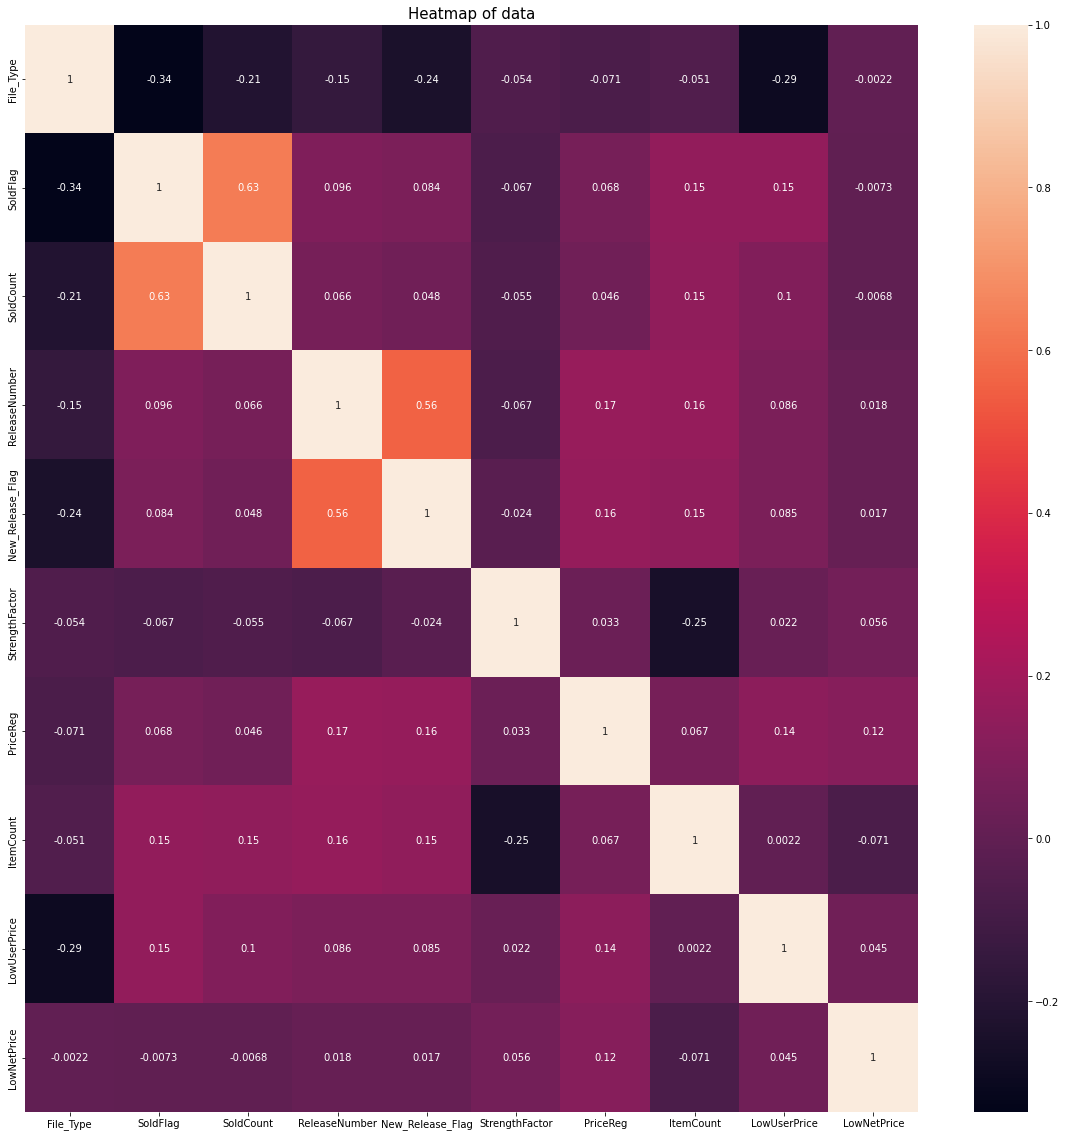

In [ ]:
sold_flag = df.loc[df['SoldFlag'] == 1.0]
print(sold_flag.shape)

plt.rcParams["figure.figsize"] = (20,20)
sns.heatmap(df.corr(),annot = True)
plt.title("Heatmap of data",fontsize= 15)
plt.show()

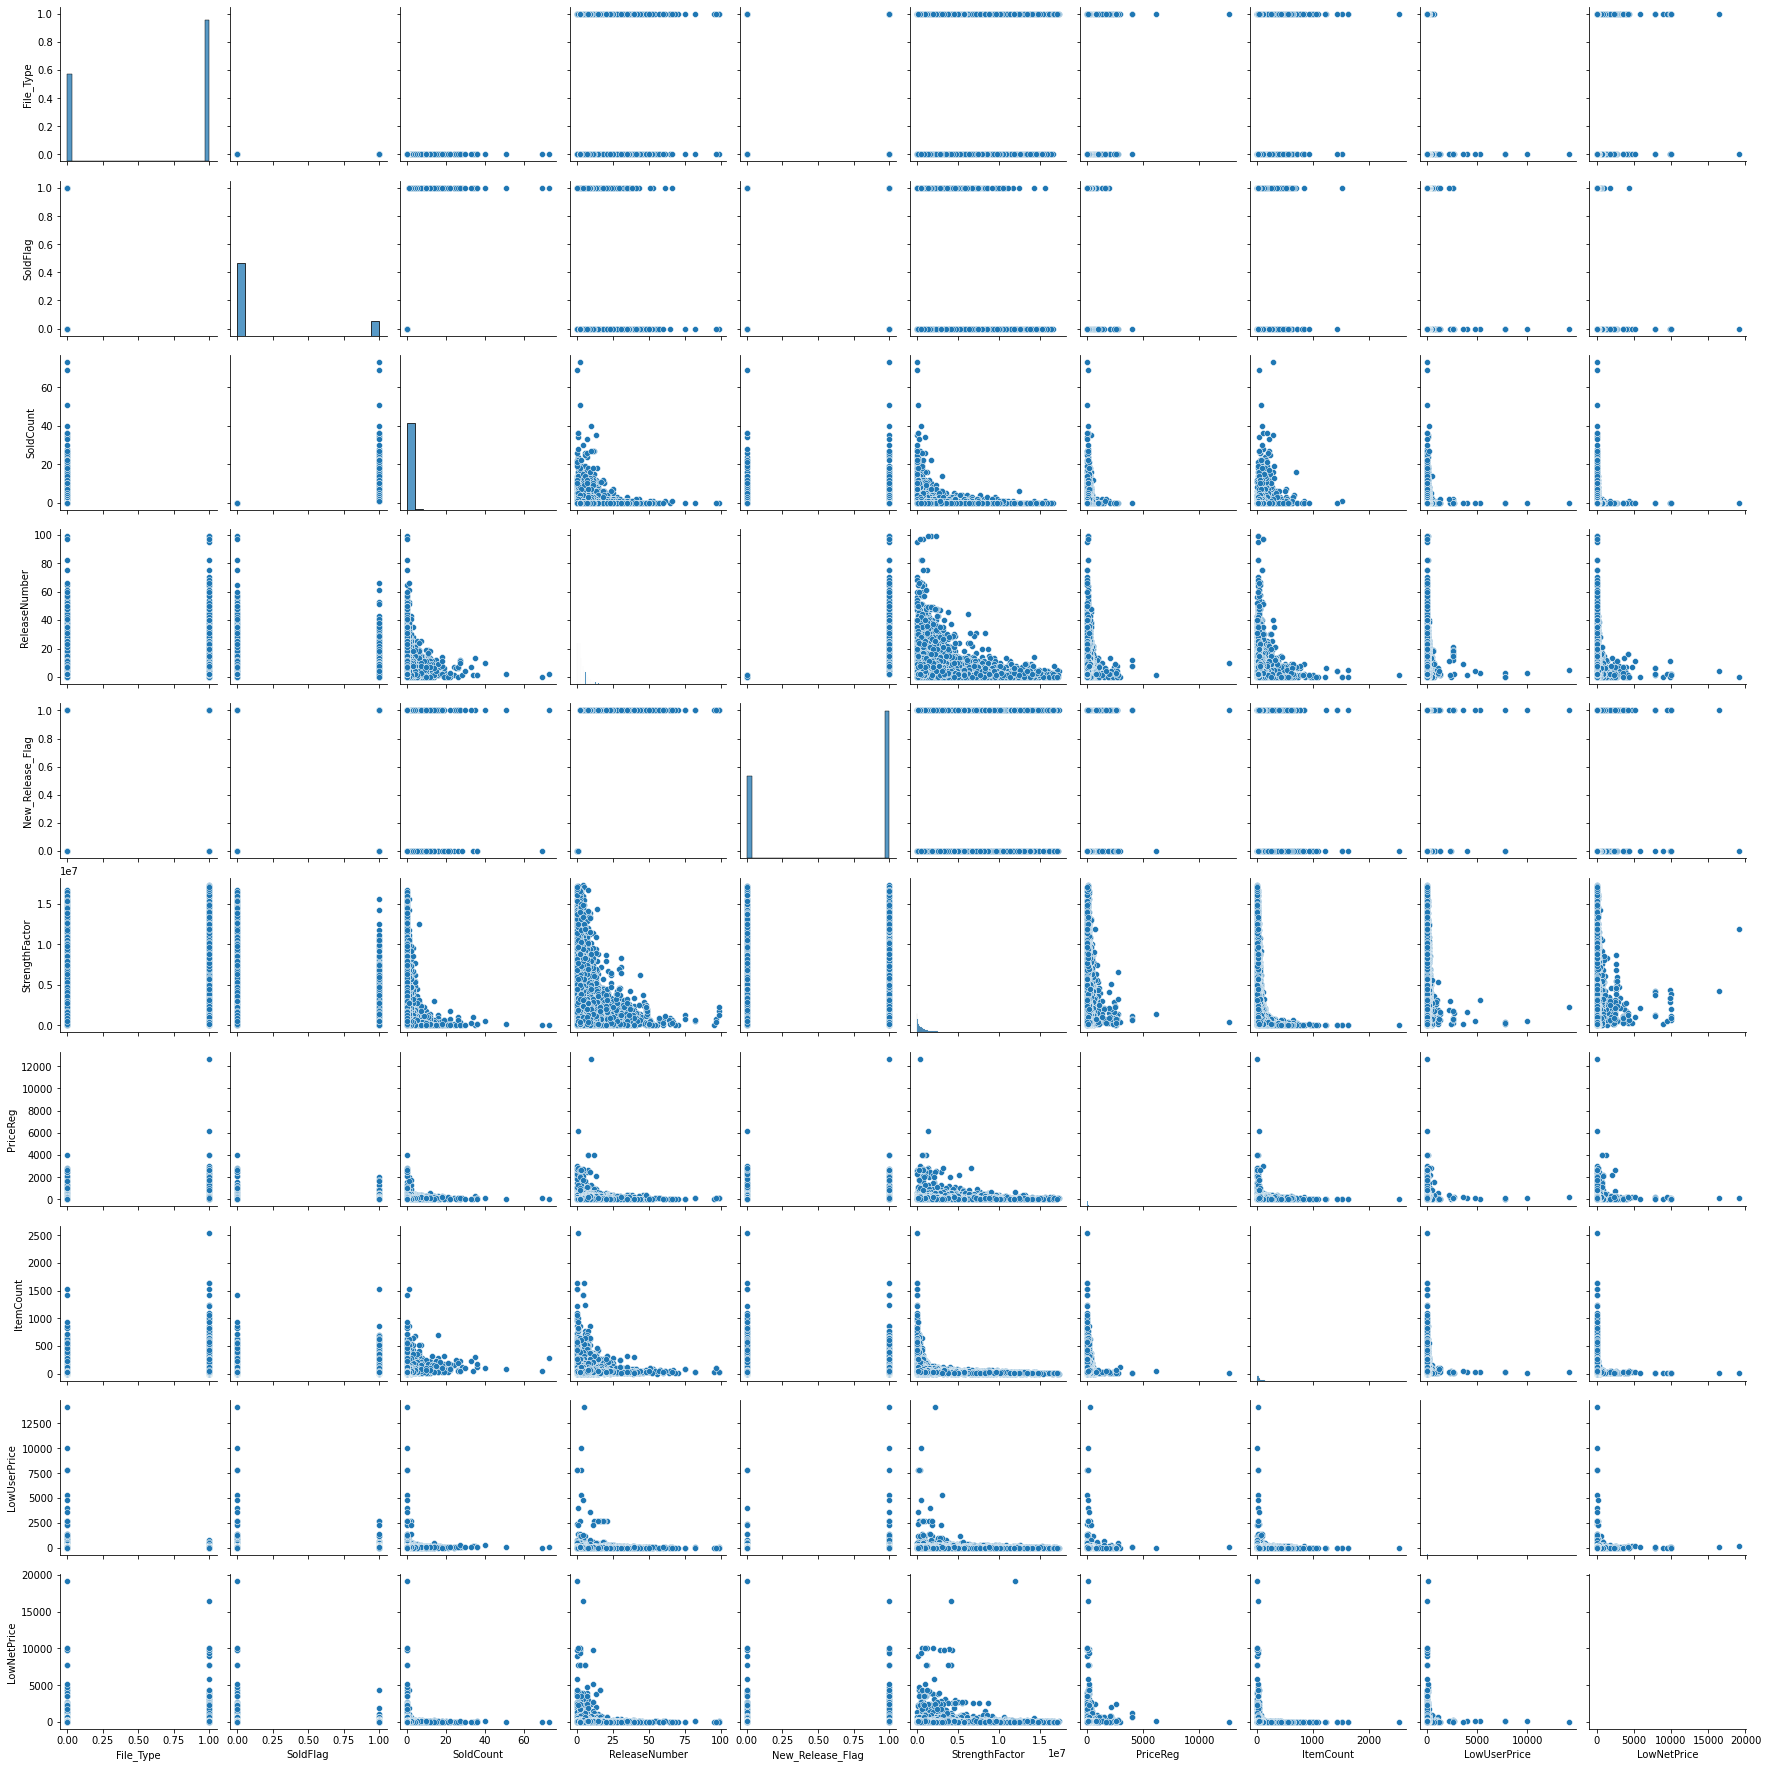

In [ ]:
#  Checking the relationship of columns with target column
sns.pairplot(df)

<Figure size 576x432 with 0 Axes>

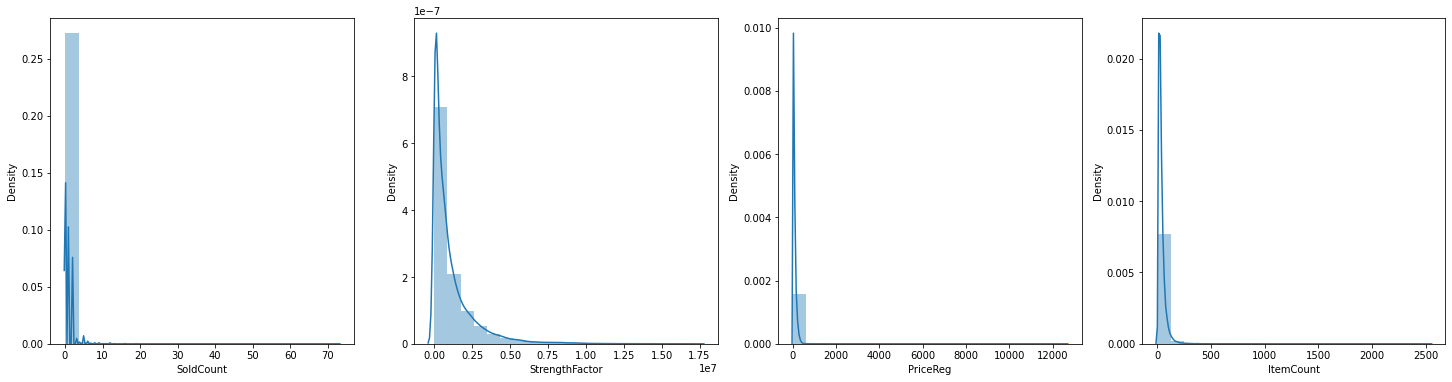

In [ ]:
#Showing Sold Count
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(25,6))
s = sns.distplot(ax = ax1, a= df['SoldCount'],bins=20)
s = sns.distplot(ax = ax2, a= df['StrengthFactor'],bins=20)
s = sns.distplot(ax = ax3, a= df['PriceReg'],bins=20)
s = sns.distplot(ax = ax4, a= df['ItemCount'],bins=20)


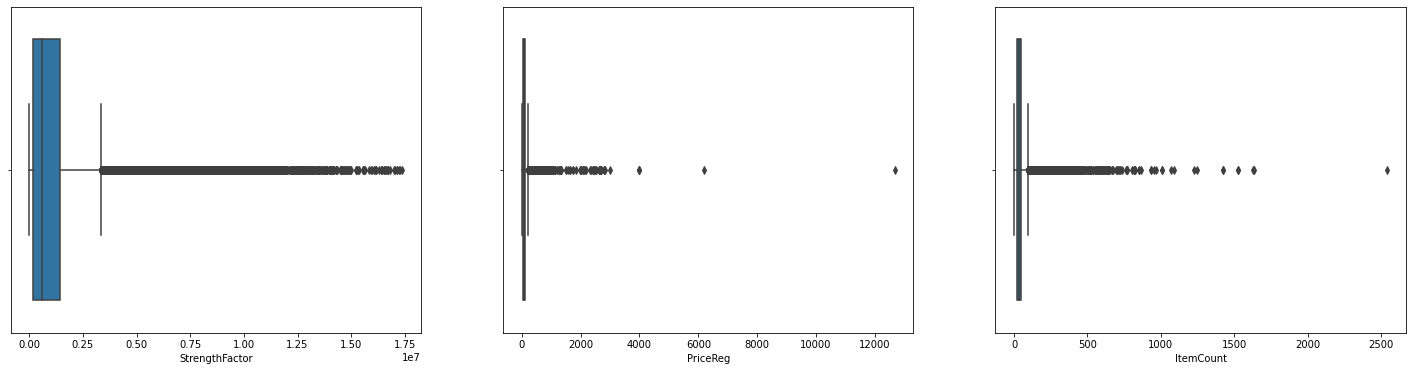

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(25,6))
s = sns.boxplot(ax = ax1, x=df["StrengthFactor"])
s = sns.boxplot(ax = ax2, x=df["PriceReg"])
s = sns.boxplot(ax = ax3, x=df["ItemCount"])

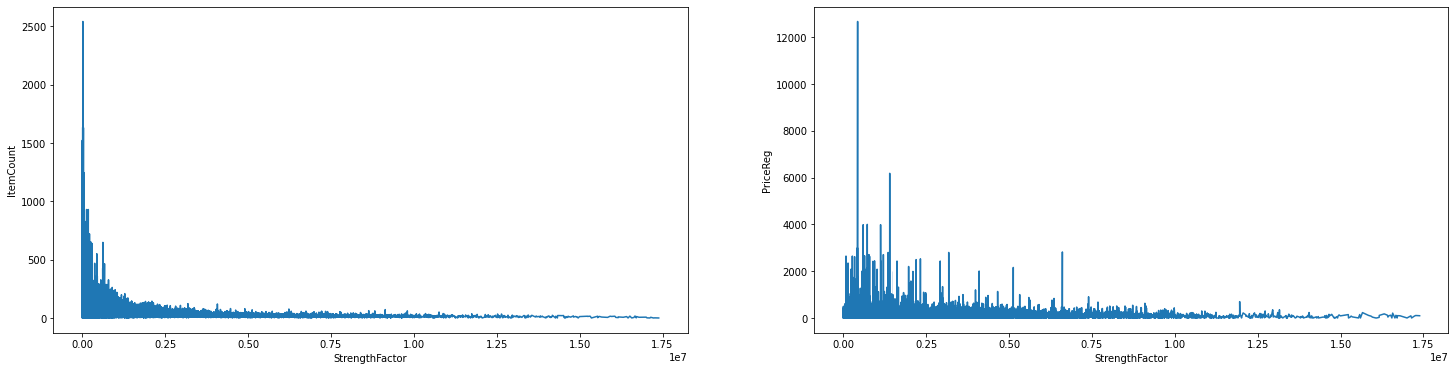

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,6))
s = sns.lineplot(ax = ax1, x=df["StrengthFactor"], y=df["ItemCount"])
s = sns.lineplot(ax = ax2, x=df["StrengthFactor"], y=df["PriceReg"])


### **Adding New Feature 'Class'**

>Each class 1,2 and 3 consists of part of the total quantity of the items and represents a part of the total value of the items in the warehouse.

>Class 1: items generally represent approximately 15%-20% of an overall inventory by item, but represent 80% of value of an inventory. Items in this class are goods which annual consumption value is the highest.

>Class 2: items represent 30%-35% of inventory items by item type, and about 15% of the value. The items in this class are goods with medium consumption value.

>Class 3: items represent 50% of actual items but only 5% of the inventory value. The items in this class are goods with the lowest consumption value.

In [ ]:
def class_segmentation(perc):
    '''
    Creates the 3 classes 1, 2, and 3 based 
    on quantity percentages (1==>60%, 2==>25%, 3==>15%)
    '''
    if perc > 0 and perc < 0.6:
        return '1'
    elif perc >= 0.6 and perc < 0.85:
        return '2'
    elif perc >= 0.85:
        return '3'

# take a subset of the data, we need to use the price and the quantity of each item
df2 = df[['PriceReg','ItemCount','File_Type','SoldFlag']]
eval=[]
eval_weight= [0.1,0.3,0.7,0.5]
for i in range(df2.shape[0]):
  if df['File_Type'][i]==0 and df['SoldFlag'][i]==0:
    eval.append(eval_weight[0])
  elif df['File_Type'][i]==1 and df['SoldFlag'][i]==0:
    eval.append(eval_weight[1])
  elif df['File_Type'][i]==1 and df['SoldFlag'][i]==1:
    eval.append(eval_weight[2])
  elif df['File_Type'][i]==0 and df['SoldFlag'][i]==1:
    eval.append(eval_weight[3])

df2['Eval']= eval


# create a, of the additive cost per SKU
df2['Add_Cost'] = df2['PriceReg'] * df2['ItemCount'] *df2['Eval']
# # # order by cumulative cost
df2['RunCumCost'] = df2['Add_Cost'].cumsum()
# # # create the column of the total sum
df2['Total'] = df2['Add_Cost'].sum() 

# # # create the column of the running percentage
df2['per'] =  df2['RunCumCost']/df2['Total'] 
df2['Class'] = df2['per'].apply(class_segmentation)
df['Class'] = df2['Class']
df2.tail(5)

,PriceReg,ItemCount,File_Type,SoldFlag,Eval,Add_Cost,RunCumCost,Total,per,Class
198912,72.87,54,1.0,0.0,0.3,1180.494,2.085614e+08,2.085685e+08,0.999966,3
198913,247.00,65,1.0,0.0,0.3,4816.500,2.085662e+08,2.085685e+08,0.999989,3
198914,50.00,23,1.0,0.0,0.3,345.000,2.085666e+08,2.085685e+08,0.999991,3
198915,46.95,23,1.0,0.0,0.3,323.955,2.085669e+08,2.085685e+08,0.999992,3
198916,120.00,44,1.0,0.0,0.3,1584.000,2.085685e+08,2.085685e+08,1.000000,3


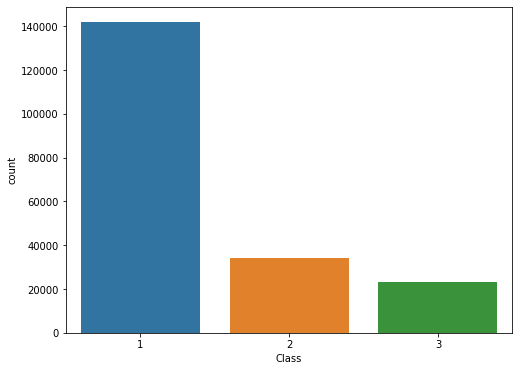

In [ ]:
count= df.Class.value_counts()
plt.figure(figsize=(8,6))
sns.countplot(df.Class)
# df.to_csv('Sale_analysis.csv')

In [ ]:
# instead of scaling the entire dataset, I'm normalising numerical columns
df['StrengthFactor']= df['StrengthFactor']/df['StrengthFactor'].mean()
df['ItemCount']= df['ItemCount']/df['ItemCount'].mean()
df['PriceReg']= df['PriceReg']/df['PriceReg'].mean()
df['LowNetPrice']= df['LowNetPrice']/df['LowNetPrice'].mean()
df['LowUserPrice']= df['LowUserPrice']/df['LowUserPrice'].mean()
df['ReleaseNumber']= df['ReleaseNumber']/df['ReleaseNumber'].mean()
df['SoldCount']= df['SoldCount']/df['SoldCount'].mean()
df.head(5)

,File_Type,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,LowNetPrice,Class
0,0.0,0.0,0.00000,4.395988,1,0.611166,0.494965,0.193114,0.935044,0.679876,1
1,0.0,0.0,0.00000,2.051461,1,0.909498,0.272952,0.941431,0.000000,0.331824,1
2,0.0,0.0,0.00000,0.000000,0,0.304771,0.506077,0.820735,0.974421,0.597241,1
3,0.0,1.0,8.12105,1.172264,1,0.298994,1.100168,0.482785,4.322765,1.775493,1
4,0.0,1.0,8.12105,0.586132,1,1.152914,1.341654,0.675899,0.129105,0.512256,1


In [ ]:
# After all the preprocessing I have downloaded this pd into csv format which I will use for MCMC implementation
df.to_csv('Sales.csv')

## **ML Algorithms**

### Evaluation Metrics

In [ ]:
# Validation metrics for classification
def validationmetrics(model, testX, testY, verbose=True):   
    predictions = model.predict(testX)
    
    if model.__class__.__module__.startswith('lightgbm'):
        for i in range(0, predictions.shape[0]):
            predictions[i]= 1 if predictions[i] >= 0.5 else 0
    
    #Accuracy
    accuracy = accuracy_score(testY, predictions)*100
    
    #Precision
    precision = precision_score(testY, predictions, pos_label=1, labels=[0,1])*100
    
    #Recall
    recall = recall_score(testY, predictions,pos_label=1,labels=[0,1])*100
    
    #get FPR (specificity) and TPR (sensitivity)
    fpr , tpr, _ = roc_curve(testY, predictions)
    
    #AUC
    auc_val = auc(fpr, tpr)
    
    #F-Score
    f_score = f1_score(testY, predictions)
    
    if verbose:
        print("Prediction Vector: \n", predictions)
        print("\n Accuracy: \n", accuracy)
        print("\n Precision of event Happening: \n", precision)
        print("\n Recall of event Happening: \n", recall)
        print("\n AUC: \n",auc_val)
        print("\n F-Score:\n", f_score)
        #confusion Matrix
        print("\n Confusion Matrix: \n", confusion_matrix(testY, predictions,labels=[0,1]))
    
    res_map = {
                "model_obj": model,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "auc_val": auc_val,
                "f_score": f_score
              }
    return res_map


#Validation metrics for Regression algorithms
def validationmetrics_reg(model,testX,testY, verbose=True):
    predictions = model.predict(testX)
    
    # R-squared
    r2 = r2_score(testY,predictions)
    
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(testX.shape[0]-1)/(testX.shape[0]-testX.shape[1]-1)
    
    # MSE
    mse = mean_squared_error(testY,predictions)
    
    #RMSE
    rmse = math.sqrt(mse)
    
    if verbose:
        print("R-Squared Value: ", r2)
        print("Adjusted R-Squared: ", r2_adjusted)
        print("RMSE: ", rmse)
    
    res_map = {
                "model_obj": model,
                "r2": r2,
                "r2_adjusted": r2_adjusted,
                "rmse": rmse
              }
    return res_map

### Classification Algorithms

In [ ]:
# Classification Algorithms

def LogReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LogisticRegression()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def KNN(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = KNeighborsClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def GradientBoosting(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def AdaBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def SVM(trainX, testX, trainY, testY, svmtype="SVC", verbose=True, clf=None):
    # for one vs all
    if not clf:
        if svmtype == "Linear":
            clf = svm.LinearSVC()
        else:
            clf = svm.SVC()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def DecisionTree(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def RandomForest(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = RandomForestClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def NaiveBayes(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GaussianNB()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def XgBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = XGBClassifier(random_state=1,learning_rate=0.01)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def LightGbm(trainX, testX, trainY, testY, verbose=True, clf=None):
    d_train = lgb.Dataset(trainX, label=trainY)
    params = {}
    params['learning_rate'] = 0.003
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = 10
    params['min_data'] = 50
    params['max_depth'] = 10
    clf = lgb.train(params, d_train, 100)
    return validationmetrics(clf,testX,testY,verbose=verbose)


### Regression Algorithms

In [ ]:
# Regression Algorithms
    
def LinearReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LinearRegression()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def RandomForestReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = RandomForestRegressor(n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def PolynomialReg(trainX, testX, trainY, testY, degree=3, verbose=True, clf=None):
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(trainX)
    poly.fit(X_poly, trainY)
    if not clf:
        clf = LinearRegression() 
    clf.fit(X_poly, trainY)
    return validationmetrics_reg(clf, poly.fit_transform(testX), testY, verbose=verbose)

def SupportVectorRegression(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = SVR(kernel="rbf")
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def DecisionTreeReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def GradientBoostingReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def AdaBooostReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostRegressor(random_state=0, n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def VotingReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100)
    # sv = SVR(kernel="rbf")
    dt = DecisionTreeRegressor()
    # gb = GradientBoostingRegressor()
    ab = AdaBoostRegressor(random_state=0, n_estimators=100)
    if not clf:
        clf = VotingRegressor([('rf', rf), ('dt', dt), ('ab', ab)])
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)


### Helper Functions

In [ ]:
# Helper function to run all algorithms provided in algo_list over given dataframe, without cross validation

# Helper function to provide list of supported algorithms for Classification
def get_supported_algorithms():
    covered_algorithms = [LogReg, KNN, GradientBoosting, AdaBoost,
                          SVM, DecisionTree, RandomForest, NaiveBayes,
                          XgBoost] #LightGbm
    return covered_algorithms
    
# Helper function to provide list of supported algorithms for Regression
def get_supported_algorithms_reg():
    covered_algorithms = [LinearReg, RandomForestReg, SupportVectorRegression,
                          DecisionTreeReg, GradientBoostingReg, AdaBooostReg, VotingReg]
    return covered_algorithms

# Helper function to scale Amount and Time as these are the inly two variable which were not scaled.
def get_scaled_df(df):
  rob_sc = RobustScaler()
  scaled_amount = rob_sc.fit_transform(df)
  
  return df

# By default it will run all supported algorithms 
def run_algorithms(df, label_col, algo_list, feature_list=[]):
    """
    Run Algorithms with manual split
    
    """
    # Lets make a copy of dataframe and work on that to be on safe side 
    _df = df.copy()
    
    if feature_list:
        impftrs = feature_list
        impftrs.append(label_col)
        _df = _df[impftrs]
    
    _df, trainX, testX, trainY, testY = traintestsplit(_df, 0.2, 91, label_col=label_col)
    algo_model_map = {}
    for algo in algo_list:
        print("============ " + algo.__name__ + " ===========")
        res = algo(trainX, testX, trainY, testY)
        algo_model_map[algo.__name__] = res.get("model_obj", None)
        print ("============================== \n")
    
    return algo_model_map
        


#Train Test Split: splitting manually
def traintestsplit(df,split,random=None, label_col=''):
    #make a copy of the label column and store in y
    y = df[label_col].copy()
    
    #now delete the original
    X = df.drop(label_col,axis=1)
    
    #manual split
    trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
    return X, trainX, testX, trainY, testY

#helper function which only splits into X and y
def XYsplit(df, label_col):
    y = df[label_col].copy()
    X = df.drop(label_col,axis=1)
    return X,y



# With stratified kfold validation support
def run_algorithms_cv(df, label_col, algo_list, feature_list=[], cross_valid_method=None):
    """
    Run Algorithms with cross validation
    
    """
    _df = df.copy()
    X,y = XYsplit(_df, label_col)
    
    # Select features if specified by driver program
    if feature_list:
        X = X[feature_list]
   
    result = {}
    algo_model_map = {}
    for algo in algo_list:
        clf = None
        result[algo.__name__] = {}
        # for trainX,trainY,testX,testY  in cross_valid_method(X, y, split=10):
        for train_index, test_index in cross_valid_method.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            res_algo = algo(X_train, X_test, y_train, y_test, verbose=False, clf=clf)
            # Get trained model so we could use it again in the next iteration
            clf = res_algo.get("model_obj", None)
            
            for k,v in res_algo.items():
                if k == "model_obj":
                    continue
                if k not in result[algo.__name__].keys():
                    result[algo.__name__][k] = list()
                result[algo.__name__][k].append(v)
                
        algo_model_map[algo.__name__] = clf
            
    score_map = {}
    # let take average scores for all folds now
    for algo, metrics in result.items():
        print("============ " + algo + " ===========")
        score_map[algo] = {}
        for metric_name, score_lst in metrics.items():
            score_map[algo][metric_name] = np.mean(score_lst)
        print(score_map[algo])
        print ("============================== \n")
        score_map[algo]["model_obj"] = algo_model_map[algo]
    
    return score_map


# Helper function to get fetaure importance metrics via Random Forest Feature Selection (RFFS)
def RFfeatureimportance(df, trainX, testX, trainY, testY, trees=35, random=None, regression=None):
    if regression:
        clf  = RandomForestRegressor(n_estimators=trees, random_state=random)
    else:
        clf  = RandomForestClassifier(n_estimators=trees, random_state=random)
    clf.fit(trainX,trainY)
    #validationmetrics(clf,testX,testY)
    res = pd.Series(clf.feature_importances_, index=df.columns.values).sort_values(ascending=False)*100
    print("Random Fores Feature Selections List: ", res)
    return res


# Helper function to select important features via RFFS, run supported ML algorithms over dataset with manual split and measure accuracy without Cross Validation - select features with importance >=threshold
def MachineLearningwithRFFS(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    df_cpy, trainX, testX, trainY, testY = traintestsplit(df_cpy, 0.2, 91, label_col=label_col)
    res = RFfeatureimportance(df_cpy, trainX, testX, trainY, testY, trees=10, regression=regression)
    
    impftrs = list(res[res > threshold].keys())
    #impftrs.append(label_col)
    
    print ("Selected Features =" + str(impftrs))
    # print(df.shape)
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=impftrs)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via RFFS, run supported ML algorithms over dataset with cross validation and measure accuracy --- select features with importance >=threshold
def MachineLearningwithRFFS_CV(df, label_col, threshold, algo_list, regression):
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    df_cpy.astype(float)
    # df_cpy = get_scaled_df(df_cpy)
    df_cpy, trainX, testX, trainY, testY = traintestsplit(df_cpy, 0.2, 91, label_col=label_col)

    # First we need to normalize the data
    # sc = StandardScaler()
    # trainX = sc.fit_transform(trainX)
    # testX = sc.transform(testX)

    res = RFfeatureimportance(df_cpy, trainX, testX, trainY, testY,
                              trees=10, regression=regression)

    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    # print(df.shape)
    cross_valid_method=None
    if regression:
      cross_valid_method = cross_valid_kfold(n_splits=10, random_state=None, shuffle=False)
    else:
      cross_valid_method = cross_valid_stratified_kf(n_splits=10, random_state=None, shuffle=False)

    results = run_algorithms_cv(df, label_col, algo_list, feature_list=impftrs, cross_valid_method=cross_valid_method)
    return {"Selected_features": impftrs, "Results": results}
    


# ## Mutual Information Feature Selection (MIFS)
# 
# MachineLearningwithMIFS() => Helper function to select important features and run supported ML algorithms over dataset

# mutualinformation()  => Helper function to get fetaure importance metrics via Mutual Information Classifier/Regressor.
def mutualinformation(df, label_col, regression=False):
    df_cpy = df.copy()
    y = df_cpy[label_col].copy()
    X = df_cpy.drop(label_col,axis=1)
    if regression:
        mutual_info = mutual_info_regression(X,y,random_state=35)
    else:
        mutual_info = mutual_info_classif(X,y,random_state=35)
    results = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)*100
    print(results)
    return results



# Helper function to select important features via MIFS, run supported ML algorithms over dataset with manual split and measure accuracy, without CV ... select features with importance >=threshold
def MachineLearningwithMIFS(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    res = mutualinformation(df_cpy, label_col=label_col, regression=regression)
    
    #include all selected features in impftrs
    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=impftrs)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via MIFS, run supported ML algorithms over dataset with manual split and measure accuracy, with CV ... select features with importance >=threshold
def MachineLearningwithMIFS_CV(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    res = mutualinformation(df_cpy, label_col=label_col, regression=regression)
    
    #include all selected features in impftrs
    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    cross_valid_method=None
    if regression:
        cross_valid_method = cross_valid_kfold
    else:
        cross_valid_method = cross_valid_stratified_kf
    results = run_algorithms_cv(df, label_col, algo_list=algo_list, feature_list=impftrs, cross_valid_method=cross_valid_method)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via REFS, run supported ML algorithms over dataset with manual split and measure accuracy, without CV ... select features with importance >=threshold
# flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features
def GenericREFS(df, label_col,
                algo_list=get_supported_algorithms(),
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=feature_list)
    return {"selected_features": feature_list, "results": results}


# Helper function to select important features via REFS, run supported ML algorithms over dataset with manual split and measure accuracy, with CV ... select features with importance >=threshold
# flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features
def GenericREFS_CV(df, label_col,
                algo_list=get_supported_algorithms(),
                regression=False,
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFECV(estimator=clf, step=1, cv=10)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    cross_valid_method= None
    if regression:
        cross_valid_method = cross_valid_kfold
    else:
        cross_valid_method = cross_valid_stratified_kf
    results = run_algorithms_cv(df, label_col, algo_list=algo_list, feature_list=feature_list, cross_valid_method=cross_valid_method)
    return {"selected_features": feature_list, "results": results}

# Helper function to provide list of classification algorithms to be used for recursive elimination feature selection
def get_supported_algorithms_refs():
    algo_list = [LogisticRegression, GradientBoostingClassifier, AdaBoostClassifier,
                          DecisionTreeClassifier, RandomForestClassifier]
    return algo_list

# Helper function to provide list of regression algorithms to be used for recursive elimination feature selection
def get_supported_reg_algorithms_refs():
    algo_list = [LinearRegression, RandomForestRegressor,
                 DecisionTreeRegressor, GradientBoostingRegressor, AdaBoostRegressor]
    return algo_list


# Helper function to perform feature selection using PCA. It runs supported algorithms with over specified components and mesure performance stats, without Cross Validation

def PCA_FS(df, label_col, n_components, algo_list=get_supported_algorithms()):
    df_cpy = df.copy()
    X,y = XYsplit(df_cpy, label_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # First we need to normalize the data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Now perform PCA
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    algo_model_map = {}
    # At this stage we apply alogorithms
    for algo in algo_list:
        print("============ " + algo.__name__ + " ===========")
        res = algo(X_train, X_test, y_train, y_test)
        algo_model_map[algo.__name__] = res.get("model_obj", None)
        
        print("============================== \n")
    return {"n_components": n_components, "results": algo_model_map}


# Helper function to perform feature selection using PCA. It runs supported algorithms with over specified components and mesure performance stats, with Cross Validation

def PCA_FS_CV(df, label_col, n_components, algo_list, regression):
  
  df_cpy = df.copy()
  df_cpy.astype(float)
  # First we need to normalize the data
  X,y = XYsplit(df_cpy, label_col)

# cross_valid_method = cross_valid_stratified_kf(n_splits=10) #if regression else cross_valid_stratified_kf 
  result = {}
  algo_model_map = {}

  if regression:
    cross_valid_method = cross_valid_kfold(n_splits=10, random_state=None, shuffle=False)
  else:
    cross_valid_method = cross_valid_stratified_kf(n_splits=10, random_state=None, shuffle=False)

  for train_index, test_index in cross_valid_method.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # First we need to normalize the data
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  for algo in algo_list:
    clf = None
    result[algo.__name__] = {} 
            
    # Now perform PCA
    pca = PCA(n_components=7)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
            
    # apply algo on this fold and save result for later usage
    res_algo = algo(X_train, X_test, y_train, y_test, verbose=False, clf=clf)
    # Get trained model so we could use it again in the next iteration
    clf = res_algo.get("model_obj", None)
            
    for k,v in res_algo.items():
      if k == "model_obj":
        continue
      if k not in result[algo.__name__].keys():
        result[algo.__name__][k] = list()
        result[algo.__name__][k].append(v)
            
    algo_model_map[algo.__name__] = clf
        
  score_map = {}
    
  # let take average scores for all folds now
  for algo, metrics in result.items():
    print("============ " + algo + " ===========")
    score_map[algo] = {}
    for metric_name, score_lst in metrics.items():
      score_map[algo][metric_name] = np.mean(score_lst)
      # print(score_map[algo])
      # print ("============================== \n")
      score_map[algo]["model_obj"] =  algo_model_map[algo]
    print(score_map[algo])
    print ("============================== \n")
  print("n_components", n_components, "results", algo_model_map)


## **Applying Classification**
>To apply classifcation algorithms, first I have used dimension reduction technique: PCA, and reduced features to 4 most important components then called classfication methods. Almost all algorithm have given ~100% accurate results.

>Similarly, used feature selection technique i.e. Random Forest, then called classification methods.Here, I have set the threshold to 3(ranking), which means below the threshold features will not be selected.
Here, again all of the algorithms have given 100% accurate results.

>Note that, the 'Class' variable which I have generated was not selected in feature selection so we cannot assume that this prediction was biased.

In [ ]:
##### PCA #####
algo_list = get_supported_algorithms()
target_label = "SoldFlag"
n_components =4
regression= False

PCA_FS_CV(df, target_label, n_components, algo_list, regression)

============ LogReg ===========
{'accuracy': 100.0, 'model_obj': LogisticRegression(), 'precision': 100.0, 'recall': 100.0, 'auc_val': 1.0, 'f_score': 1.0}

============ KNN ===========
{'accuracy': 99.97989040269468, 'model_obj': KNeighborsClassifier(), 'precision': 100.0, 'recall': 99.69207082371054, 'auc_val': 0.9984603541185527, 'f_score': 0.9984579799537394}

============ GradientBoosting ===========
{'accuracy': 99.9145342114524, 'model_obj': GradientBoostingClassifier(), 'precision': 99.53632148377125, 'recall': 99.153194765204, 'auc_val': 0.9956046141014073, 'f_score': 0.9934438873891246}

============ AdaBoost ===========
{'accuracy': 99.94972600673671, 'model_obj': AdaBoostClassifier(n_estimators=100, random_state=0), 'precision': 99.53881629515757, 'recall': 99.69207082371054, 'auc_val': 0.99829899439394, 'f_score': 0.9961538461538462}

============ SVM ===========
{'accuracy': 99.98994520134734, 'model_obj': SVC(), 'precision': 100.0, 'recall': 99.84603541185527, 'auc_val':

In [ ]:
#### RFS ####
algo_list = [LogReg, AdaBoost, SVM, DecisionTree, RandomForest, XgBoost]
target_label = "SoldFlag"
threshold=3
regression=False

MachineLearningwithRFFS_CV(df, target_label, threshold, algo_list, regression)

Random Fores Feature Selections List:  SoldCount           88.339013
File_Type            6.603768
LowUserPrice         2.633925
ItemCount            0.935385
Class                0.572053
StrengthFactor       0.439435
ReleaseNumber        0.283357
LowNetPrice          0.095117
PriceReg             0.085797
New_Release_Flag     0.012151
dtype: float64
Selected Features =['SoldCount', 'File_Type']
============ LogReg ===========
{'accuracy': 100.0, 'precision': 100.0, 'recall': 100.0, 'auc_val': 1.0, 'f_score': 1.0}

============ AdaBoost ===========
{'accuracy': 100.0, 'precision': 100.0, 'recall': 100.0, 'auc_val': 1.0, 'f_score': 1.0}

============ SVM ===========
{'accuracy': 100.0, 'precision': 100.0, 'recall': 100.0, 'auc_val': 1.0, 'f_score': 1.0}

============ DecisionTree ===========
{'accuracy': 100.0, 'precision': 100.0, 'recall': 100.0, 'auc_val': 1.0, 'f_score': 1.0}

============ RandomForest ===========
{'accuracy': 100.0, 'precision': 100.0, 'recall': 100.0, 'auc_val': 1

{'Results': {'AdaBoost': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': AdaBoostClassifier(n_estimators=100, random_state=0),
   'precision': 100.0,
   'recall': 100.0},
  'DecisionTree': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': DecisionTreeClassifier(),
   'precision': 100.0,
   'recall': 100.0},
  'LogReg': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': LogisticRegression(),
   'precision': 100.0,
   'recall': 100.0},
  'RandomForest': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': RandomForestClassifier(),
   'precision': 100.0,
   'recall': 100.0},
  'SVM': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': SVC(),
   'precision': 100.0,
   'recall': 100.0},
  'XgBoost': {'accuracy': 100.0,
   'auc_val': 1.0,
   'f_score': 1.0,
   'model_obj': XGBClassifier(learning_rate=0.01, random_state=1),
   'precision': 100.0,
   'recall': 100.0}},
 'Selected

## **Applying Regression** 
> Although the dataset was clearly a classification problem. But still just for testing it with some regression algorithms, first I have used dimension reduction technique: PCA, and reduced features to 4 most important components then called regression methods. All algorithms have given 0 in r-square which shows that these algorithms are failed terribly.

>Similarly, used feature selection technique i.e. Random Forest, then called regression methods. Here, again I have set the threshold to 3(ranking). We did not see any hope in implementing regression.

In [ ]:
#### PCA #####
algo_list = [RandomForestReg,DecisionTreeReg, GradientBoostingReg, AdaBooostReg]
target_label = "SoldFlag"
n_components =4
regression= True

PCA_FS_CV(df, target_label, n_components, algo_list, regression)

============ RandomForestReg ===========
{'r2': 0.0, 'model_obj': RandomForestRegressor(), 'r2_adjusted': -0.0003520595483579303, 'rmse': 0.017057571222517623}

============ DecisionTreeReg ===========
{'r2': 0.0, 'model_obj': DecisionTreeRegressor(), 'r2_adjusted': -0.0003520595483579303, 'rmse': 0.04194746433594016}

============ GradientBoostingReg ===========
{'r2': 0.0, 'model_obj': GradientBoostingRegressor(), 'r2_adjusted': -0.0003520595483579303, 'rmse': 0.0496757151948846}

============ AdaBooostReg ===========
{'r2': 0.0, 'model_obj': AdaBoostRegressor(n_estimators=100, random_state=0), 'r2_adjusted': -0.0003520595483579303, 'rmse': 0.09444851322607982}

n_components 4 results {'RandomForestReg': RandomForestRegressor(), 'DecisionTreeReg': DecisionTreeRegressor(), 'GradientBoostingReg': GradientBoostingRegressor(), 'AdaBooostReg': AdaBoostRegressor(n_estimators=100, random_state=0)}


In [ ]:
#### RFS ####
algo_list = [RandomForestReg,DecisionTreeReg, GradientBoostingReg, AdaBooostReg]
target_label = "SoldFlag"
threshold=3
regression=True

MachineLearningwithRFFS_CV(df, target_label, threshold, algo_list, regression)

Random Fores Feature Selections List:  SoldCount           100.0
Class                 0.0
LowNetPrice           0.0
LowUserPrice          0.0
ItemCount             0.0
PriceReg              0.0
StrengthFactor        0.0
New_Release_Flag      0.0
ReleaseNumber         0.0
File_Type             0.0
dtype: float64
Selected Features =['SoldCount']
============ RandomForestReg ===========
{'r2': 1.0, 'r2_adjusted': 1.0, 'rmse': 0.0}

============ DecisionTreeReg ===========
{'r2': 1.0, 'r2_adjusted': 1.0, 'rmse': 0.0}

============ GradientBoostingReg ===========
{'r2': 0.39999999968792704, 'r2_adjusted': 0.39996983301703576, 'rmse': 5.153802910901954e-06}

============ AdaBooostReg ===========
{'r2': 1.0, 'r2_adjusted': 1.0, 'rmse': 0.0}



{'Results': {'AdaBooostReg': {'model_obj': AdaBoostRegressor(n_estimators=100, random_state=0),
   'r2': 1.0,
   'r2_adjusted': 1.0,
   'rmse': 0.0},
  'DecisionTreeReg': {'model_obj': DecisionTreeRegressor(),
   'r2': 1.0,
   'r2_adjusted': 1.0,
   'rmse': 0.0},
  'GradientBoostingReg': {'model_obj': GradientBoostingRegressor(),
   'r2': 0.39999999968792704,
   'r2_adjusted': 0.39996983301703576,
   'rmse': 5.153802910901954e-06},
  'RandomForestReg': {'model_obj': RandomForestRegressor(),
   'r2': 1.0,
   'r2_adjusted': 1.0,
   'rmse': 0.0}},
 'Selected_features': ['SoldCount']}